# SARSA algorithm

In [1]:
import gym
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

Declare hyperparameters for model training.

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
GAMMA = 0.99
LR = 0.001
EPSILON_DECAY_RATE = 0.9999
N_STEP = 4

#### gamma
The cartpole environment gives a reward of +1 every time before the stick collapses. Therefore, if gamma is set to 1, the value of the q function is diverged, so the q network cannot be trained theoretically (In fact, even if gamma is 1, it is possible to search for an optimal policy to some extent). In order to accurately get the q function when gamma is 1, note that the maximum time steps of one episode is 500 in the cartpole-v1 environment. Using this, we can make a neural network whose input states include time. In this tutorial, to simplify the problem, only the state condition basically given in the cartpole environment was used.

### Building SARSA network using PyTorch

First we build q network, which approximates the q function in the Cartpole environment, and create a SARSA class that performs model training and agent behavior.

In [3]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_size, 32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,32)
        self.fc4 = nn.Linear(32, act_size)

    def forward(self, s):
        q = F.relu(self.fc1(s))
        q = F.relu(self.fc2(q))
        q = F.relu(self.fc3(q))
        q = self.fc4(q)

        return q


class SARSA():
    def __init__(self, q_network, epsilon=1):
        self.net = q_network
        self.epsilon = epsilon
        self.min_epsilon = 0.01
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), LR)
        
    def get_action(self, s):
        s_tensor = (torch.from_numpy(s)).float().to(DEVICE) 

        # epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            a = np.random.randint(act_size)
        else:
            q = self.net(s_tensor).detach()
            a = torch.argmax(q).item()
        return a
    
    def store_state(self, state):
        self.state_buffer.append(state)

    def store_action(self, action):
        self.action_buffer.append(action)        
        
    def store_reward(self, reward):
        self.reward_buffer.append(reward)
    
    def reset_all_buffer(self):
        self.state_buffer.clear()
        self.action_buffer.clear()
        self.reward_buffer.clear()

    def update(self, tau, T):      
        self.epsilon = max(self.min_epsilon, self.epsilon * EPSILON_DECAY_RATE)
        s_now = torch.tensor(self.state_buffer[0]).reshape(1,obs_size).float().to(DEVICE)
        s_last = torch.tensor(self.state_buffer[-1]).reshape(1,obs_size).float().to(DEVICE)
        a_now = torch.tensor(self.action_buffer[0]).reshape(1,1).long().to(DEVICE)
        a_last = torch.tensor(self.action_buffer[-1]).reshape(1,1).long().to(DEVICE)
               
        gammas = np.array([GAMMA**i for i in range(len(self.reward_buffer))])
        G = np.sum(np.array(self.reward_buffer) * gammas)
        G = torch.tensor(G, dtype=torch.float, device=DEVICE).reshape(1,1)
        if tau + N_STEP < T:
            G += (GAMMA**N_STEP) * torch.gather(self.net(s_last), 1, a_last)
        q = torch.gather(self.net(s_now), 1, a_now)
        loss = self.criterion(q, G.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.state_buffer.pop(0)
        self.action_buffer.pop(0)
        self.reward_buffer.pop(0)

        return loss.detach().cpu().numpy()




### Visualization of training

Next, to visualize the training, we define a class that draws a loss function and cumulative rewards as training progresses.

In [4]:
class Graph():
    def __init__(self):
        self.max_num_data = 200
        
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 4))
        self.loss_graph, = self.ax[0].plot(1)
        self.reward_graph, = self.ax[1].plot(1)
        self.ax[0].set_title("Loss")
        self.ax[0].set_xlim(0,1)
        self.ax[0].set_ylim(0,2)
        self.ax[0].set_yscale('log')
        self.ax[0].set_xlabel('step')
        self.ax[0].set_ylabel('loss')
        self.ax[1].set_title("Cumulative reward")
        self.ax[1].set_xlim(0,10)
        self.ax[1].set_ylim(0,2)
        self.ax[1].set_xlabel('episode')
        self.ax[1].set_ylabel('reward')

    
    def update_loss(self, loss_list):
        while len(loss_list) > self.max_num_data:
            loss_list = [data for idx, data in enumerate(loss_list) if idx %2 == 0]
        
        x = [i[0] for i in loss_list]
        y = [i[1] for i in loss_list]        
        self.ax[0].set_xlim(0,x[-1])
        self.ax[0].set_ylim(np.min(y)*0.9,np.max(y)*1.1)
        self.loss_graph.set_xdata(x)
        self.loss_graph.set_ydata(y)        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()     
        
    def update_reward(self, reward_list):
        while len(reward_list) > self.max_num_data:
            reward_list = [data for idx, data in enumerate(reward_list) if idx %2 == 0]
        
        x = [i[0] for i in reward_list]
        y = [i[1] for i in reward_list]        
        self.ax[1].set_xlim(0,x[-1])
        self.ax[1].set_ylim(np.min(y)*0.9, np.max(y)*1.1)
        self.reward_graph.set_xdata(x)
        self.reward_graph.set_ydata(y)        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()    

### Training the model

Create an Cartpole environment and instances of our SARSA model.

In [5]:
env = gym.make("CartPole-v1")
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
q_network = QNetwork().to(DEVICE)
agent = SARSA(q_network)

After setting the training related variables, execute the cartpole environment. Upon receiving the observation state from the environment, agent acts depending on the value of q calculated through the q network and the epsilon greedy policy. As a result, the agent gets a reward and moves on to the next state.

Originally, the SARSA algorithm does not use mini-batch training, but updates every iteration. In this example, however, we use the neural network approximation for the q function and allow the model to be trained by applying mini-batch training.

<IPython.core.display.Javascript object>


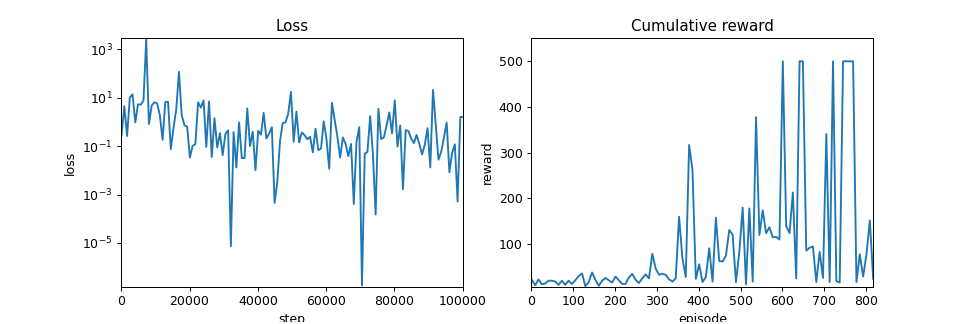

In [6]:
%matplotlib notebook
plt.ion()
graph = Graph()
loss_list = []
reward_list = []
loss_record_term = 100
max_steps = 100000
episode = 0
total_step = 0

while total_step < max_steps:
    episode += 1
    cum_reward = 0
    agent.reset_all_buffer()
    state = env.reset()
    agent.store_state(state)
    action = agent.get_action(state)
    agent.store_action(action)
    
    T = np.inf
    t = 0
    while True :
        t += 1
        total_step += 1
        #env.render()
        if t < T:
            next_state, reward, done, info = env.step(action)
            agent.store_state(next_state)
            agent.store_reward(reward)
            cum_reward += reward
            
            if done : 
                T = t+1
            else:
                next_action = agent.get_action(next_state)
                agent.store_action(next_action)
        
        tau = t-N_STEP+1
        if tau >=0:
            loss = agent.update(tau, T)
            
        action = next_action
        state = next_state
        

        # record loss
        if total_step % loss_record_term == 0: 
            loss_list.append([total_step,loss])
            graph.update_loss(loss_list)

        # terminated
        if t == T-1:
            reward_list.append([episode, cum_reward])
            graph.update_reward(reward_list)
            break
env.close()